In [14]:
import os
import shutil
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [15]:
# Define some parameters
BATCH_SIZE = 32  # Batch size for training and testing
IMAGE_SIZE = 256  # Size of the images
EPOCHS = 70  # Number of epochs for training
NUM_CLASSES = 2  # Number of classes (cancer and no cancer)
DATA_DIR = r"D:\\python\\oral cancer detection\\my_dataset"  # Directory where the original data is stored
TRAIN_SPLIT = 0.8  # Fraction of data used for training
VAL_SPLIT = 0.1  # Fraction of data used for validation
TEST_SPLIT = 0.1  # Fraction of data used for testing
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise CPU

In [16]:
# Create temporary directory to store split datasets
TEMP_DIR = r"D:\python\oral cancer detection\temp_dataset"  # Directory where the split data will be stored
os.makedirs(TEMP_DIR, exist_ok=True)  # Create the temporary directory if it does not exist


In [17]:
# Split the dataset into training, validation, and testing sets
def split_data(data_dir, temp_dir, train_split, val_split, test_split):
    for category in ['cancer', 'non_cancer']:  # Loop through each category (class)
        category_path = os.path.join(data_dir, category)  # Path to the category directory
        images = os.listdir(category_path)  # List of images in the category
        np.random.shuffle(images)  # Shuffle the list of images
        
        train_size = int(train_split * len(images))  # Number of images for training
        val_size = int(val_split * len(images))  # Number of images for validation
        test_size = len(images) - train_size - val_size  # Number of images for testing
        
        train_images = images[:train_size]  # Training images
        val_images = images[train_size:train_size + val_size]  # Validation images
        test_images = images[train_size + val_size:]  # Testing images
        
        for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
            split_dir = os.path.join(temp_dir, split, category)  # Path to the split directory
            os.makedirs(split_dir, exist_ok=True)  # Create the split directory if it does not exist
            for image in split_images:  # Loop through each image in the split
                src = os.path.join(category_path, image)  # Source path of the image
                dst = os.path.join(split_dir, image)  # Destination path of the image
                shutil.copyfile(src, dst)  # Copy the image to the destination path

split_data(DATA_DIR, TEMP_DIR, TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT)  # Call the function to split the data


In [19]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([  # Transformations for the training dataset
        transforms.RandomResizedCrop(IMAGE_SIZE),  # Randomly crop and resize images
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.ToTensor(),  # Convert images to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ]),
    'val': transforms.Compose([  # Transformations for the validation dataset
        transforms.Resize(IMAGE_SIZE),  # Resize images
        transforms.CenterCrop(IMAGE_SIZE),  # Center crop images
        transforms.ToTensor(),  # Convert images to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ]),
    'test': transforms.Compose([  # Transformations for the test dataset
        transforms.Resize(IMAGE_SIZE),  # Resize images
        transforms.CenterCrop(IMAGE_SIZE),  # Center crop images
        transforms.ToTensor(),  # Convert images to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ]),
}

In [22]:
def main():
    # Load the datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(TEMP_DIR, x),  # Load dataset for each split
                                              data_transforms[x])  # Apply the corresponding transformations
                      for x in ['train', 'val', 'test']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE,  # Create data loaders for each split
                                 shuffle=True, num_workers=4)  # Enable shuffling and parallel loading
                   for x in ['train', 'val', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  # Get the sizes of each dataset
    class_names = image_datasets['train'].classes  # Get class names from the training dataset

    print(f"Classes: {class_names}")  # Print class names
    print(f"Training dataset size: {dataset_sizes['train']}")  # Print size of the training dataset
    print(f"Validation dataset size: {dataset_sizes['val']}")  # Print size of the validation dataset
    print(f"Test dataset size: {dataset_sizes['test']}")  # Print size of the test dataset

    # Define the model
    import torchvision.models as models

    model = models.resnet18(pretrained=True)  # Load a pre-trained ResNet18 model
    num_ftrs = model.fc.in_features  # Get the number of features in the fully connected layer
    model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)  # Replace the fully connected layer with a new one for our number of classes
    model = model.to(DEVICE)  # Move the model to the specified device (GPU or CPU)

    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()  # Loss function for classification
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

    # Train the model
    import copy

    best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
    best_acc = 0.0  # Initialize the best accuracy

    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    train_accuracies = []  # List to store training accuracies
    val_accuracies = []  # List to store validation accuracies

    for epoch in range(EPOCHS):  # Loop through each epoch
        print(f'Epoch {epoch}/{EPOCHS - 1}')  # Print the current epoch
        print('-' * 10)
        
        for phase in ['train', 'val']:  # Loop through each phase (training and validation)
            if phase == 'train':  # Set the model to training mode
                model.train()
            else:  # Set the model to evaluation mode
                model.eval()

            running_loss = 0.0  # Initialize running loss
            running_corrects = 0  # Initialize running correct predictions

            for inputs, labels in dataloaders[phase]:  # Loop through each batch
                inputs = inputs.to(DEVICE)  # Move inputs to the device
                labels = labels.to(DEVICE)  # Move labels to the device

                optimizer.zero_grad()  # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'):  # Enable gradient computation only for training phase
                    outputs = model(inputs)  # Forward pass
                    _, preds = torch.max(outputs, 1)  # Get predictions
                    loss = criterion(outputs, labels)  # Compute loss

                    if phase == 'train':  # Backward pass and optimization only in training phase
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)  # Accumulate loss
                running_corrects += torch.sum(preds == labels.data)  # Accumulate correct predictions

            epoch_loss = running_loss / dataset_sizes[phase]  # Calculate average loss for the epoch
            epoch_acc = running_corrects.double() / dataset_sizes[phase]  # Calculate accuracy for the epoch

            if phase == 'train':  # Store training metrics
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu())  # Move accuracy tensor to CPU before storing
            else:  # Store validation metrics
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu())  # Move accuracy tensor to CPU before storing

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')  # Print loss and accuracy

            if phase == 'val' and epoch_acc > best_acc:  # Check if this is the best model
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())  # Update best model weights

    print(f'Best val Acc: {best_acc:.4f}')  # Print the best validation accuracy

    model.load_state_dict(best_model_wts)  # Load best model weights

    # Test the model
    model.eval()  # Set the model to evaluation mode
    running_corrects = 0  # Initialize running correct predictions

    for inputs, labels in dataloaders['test']:  # Loop through each batch
        inputs = inputs.to(DEVICE)  # Move inputs to the device
        labels = labels.to(DEVICE)  # Move labels to the device

        with torch.no_grad():  # Disable gradient computation
            outputs = model(inputs)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predictions

        running_corrects += torch.sum(preds == labels.data)  # Accumulate correct predictions

    test_acc = running_corrects.double() / dataset_sizes['test']  # Calculate accuracy for the test set
    print(f'Test accuracy: {test_acc:.4f}')  # Print test accuracy

    # Save the model
    torch.save(model.state_dict(), "Oral_cancer_detection.pth")  # Save the model weights

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot([acc.item() for acc in train_accuracies], label='Training Accuracy')  # Convert tensor to item
    plt.plot([acc.item() for acc in val_accuracies], label='Validation Accuracy')  # Convert tensor to item
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Predict using the trained model
    def predict_image(image_path, model, transform, class_names):
        model.eval()  # Set the model to evaluation mode
        image = Image.open(image_path).convert('RGB')  # Open and convert the image to RGB
        image = transform(image).unsqueeze(0).to(DEVICE)  # Apply transformations and add batch dimension
        with torch.no_grad():  # Disable gradient computation
            output = model(image)  # Forward pass
            _, predicted = torch.max(output, 1)  # Get predictions
        return class_names[predicted[0]]  # Return the predicted class name

    # Example prediction
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize image
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image
    ])

    image_path = r"D:\python\oral cancer detection\my_dataset\cancer\3-s2.0-B9780443100734500148-f10-07-9780443100734.jpg"  # Path to the image
    predicted_class = predict_image(image_path, model, transform, class_names)  # Predict the class of the image
    print(f"The predicted class is: {predicted_class}")  # Print the predicted class

    # Display the image
    image = Image.open(image_path)  # Open the image
    plt.imshow(image)  # Display the image
    plt.title(f'Predicted Class: {predicted_class}')  # Set the title with predicted class
    plt.show()  # Show the plot

Classes: ['cancer', 'non_cancer']
Training dataset size: 1231
Validation dataset size: 1231
Test dataset size: 1231
Epoch 0/69
----------
train Loss: 0.6887 Acc: 0.6742
val Loss: 0.8620 Acc: 0.6377
Epoch 1/69
----------
train Loss: 0.5494 Acc: 0.7100
val Loss: 0.7483 Acc: 0.6921
Epoch 2/69
----------
train Loss: 0.4717 Acc: 0.7888
val Loss: 0.5090 Acc: 0.7807
Epoch 3/69
----------
train Loss: 0.4376 Acc: 0.8091
val Loss: 0.4018 Acc: 0.8050
Epoch 4/69
----------
train Loss: 0.3979 Acc: 0.8335
val Loss: 0.9211 Acc: 0.6856
Epoch 5/69
----------
train Loss: 0.3726 Acc: 0.8473
val Loss: 0.2846 Acc: 0.8790
Epoch 6/69
----------
train Loss: 0.3937 Acc: 0.8359
val Loss: 0.7741 Acc: 0.7287
Epoch 7/69
----------
train Loss: 0.3761 Acc: 0.8359
val Loss: 3.6900 Acc: 0.5386
Epoch 8/69
----------
train Loss: 0.3736 Acc: 0.8448
val Loss: 0.2527 Acc: 0.9001
Epoch 9/69
----------
train Loss: 0.3521 Acc: 0.8513
val Loss: 0.2162 Acc: 0.9058
Epoch 10/69
----------
train Loss: 0.3315 Acc: 0.8668
val Loss: 

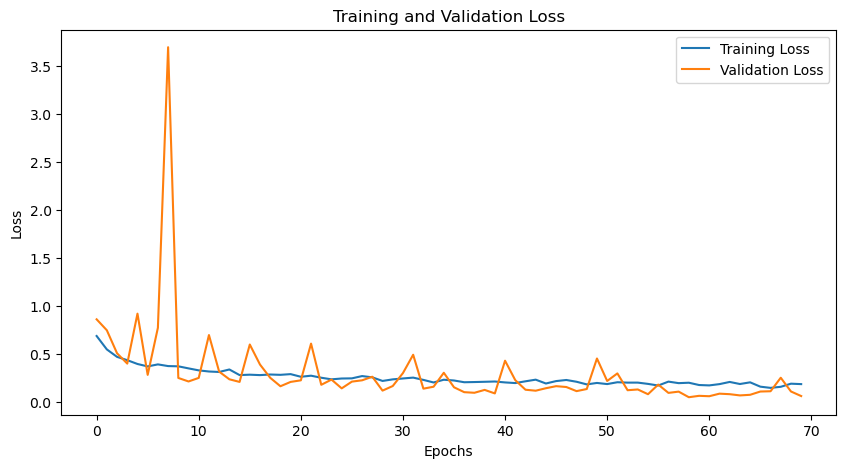

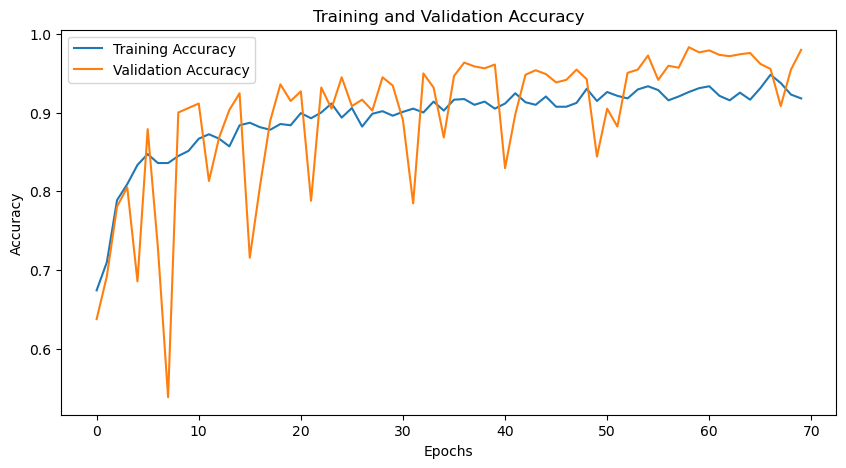

The predicted class is: cancer


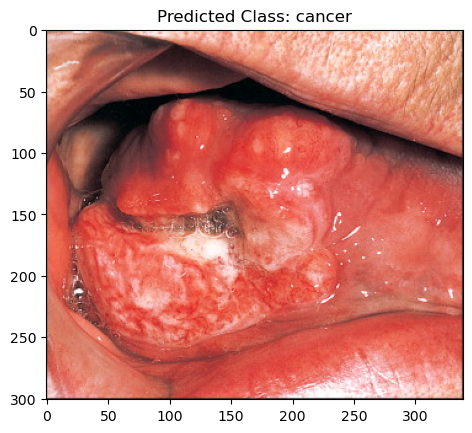

In [23]:

if __name__ == '__main__':
    main()  # Run the main function
